# Retail Price Optimization

In [ ]:
# Retail Price Optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import zipfile

In [2]:
# Extract the ZIP file
zip_file_path = 'Retail Price Optimization.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('retail_price_data')

# Load the dataset
csv_file_path = 'retail_price_data/retail_price.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())


Dataset Overview:
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0              

In [3]:
# Data Inspection
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday              

In [ ]:
# Explore the Data

# Visualization: Distribution of Demand and Prices
def plot_distributions(data):
    plt.figure(figsize=(14, 7))
    sns.histplot(data['qty'], kde=True, bins=30, color='blue', label='Demand')
    sns.histplot(data['unit_price'], kde=True, bins=30, color='green', label='Unit Price')
    plt.title("Distribution of Demand and Unit Prices")
    plt.legend()
    plt.show()

plot_distributions(data)

# Select only numerical columns
numerical_data = data.select_dtypes(include=[np.number])

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [4]:
# Feature Engineering and Cleaning

# Normalize numerical features
scaler = MinMaxScaler()
numeric_features = ['unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Add interaction features
interaction_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_data = interaction_features.fit_transform(data[numeric_features])
interaction_df = pd.DataFrame(interaction_data, columns=interaction_features.get_feature_names_out(numeric_features))
data = pd.concat([data, interaction_df], axis=1)

# One-Hot Encoding for Categorical Features
encoded_data = pd.get_dummies(data['product_category_name'], prefix='category')

# Combine Encoded Features
data = pd.concat([data, encoded_data], axis=1)

# Prepare features and target
features = list(interaction_df.columns) + list(encoded_data.columns)
X = data[features]
y = data['qty']

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=50, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best Model
best_rf_model = random_search.best_estimator_

# Model Evaluation
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 183.32
Mean Absolute Error: 10.14
Mean Absolute Percentage Error: 2.39
R² Score: 0.32


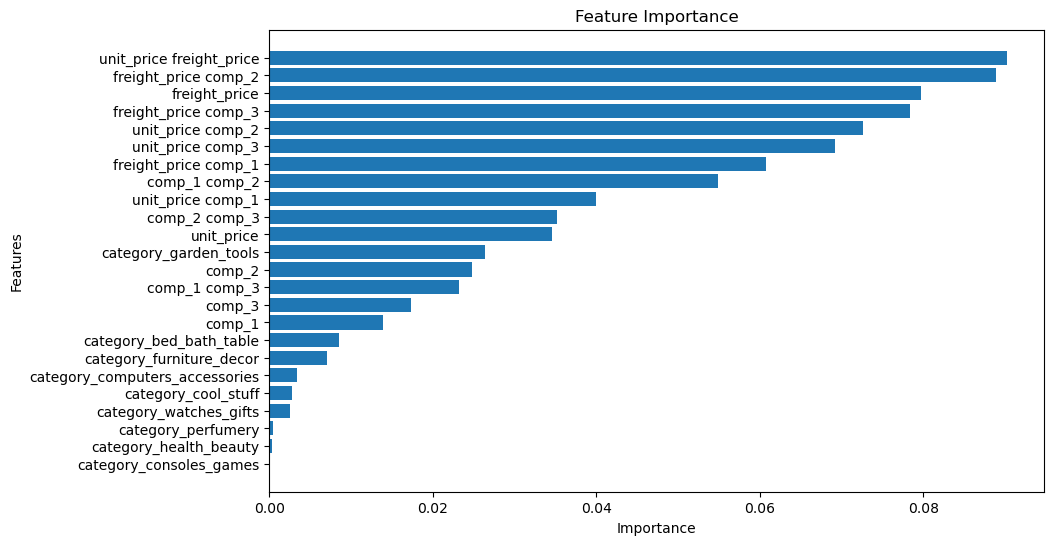

In [8]:
# Feature Importance
plt.figure(figsize=(10, 6))

# Dynamically get the feature names from the training data
sorted_idx = np.argsort(best_rf_model.feature_importances_)
feature_names = X_train.columns  # Extract column names from X_train
sorted_features = np.array(feature_names)[sorted_idx]

# Plot the feature importances
plt.barh(sorted_features, best_rf_model.feature_importances_[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
# Price Optimization

In [18]:
# Ensure 'Price_Elasticity' is calculated
if 'Price_Elasticity' not in data.columns:
    data = data[data['unit_price'] > 0]  # Remove rows with zero or negative prices
    data['Price_Elasticity'] = data['qty'] / data['unit_price']

# Ensure features match training features
features = [
    'unit_price', 'freight_price', 'Price_Elasticity', 'comp_1', 'comp_2', 'comp_3',
    'unit_price freight_price', 'unit_price comp_1', 'unit_price comp_2', 'unit_price comp_3',
    'freight_price comp_1', 'freight_price comp_2', 'freight_price comp_3',
    'comp_1 comp_2', 'comp_1 comp_3', 'comp_2 comp_3',
    'category_bed_bath_table', 'category_computers_accessories',
    'category_consoles_games', 'category_cool_stuff',
    'category_furniture_decor', 'category_garden_tools',
    'category_health_beauty', 'category_perfumery',
    'category_watches_gifts'
]

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Optimal Price: 1.00


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


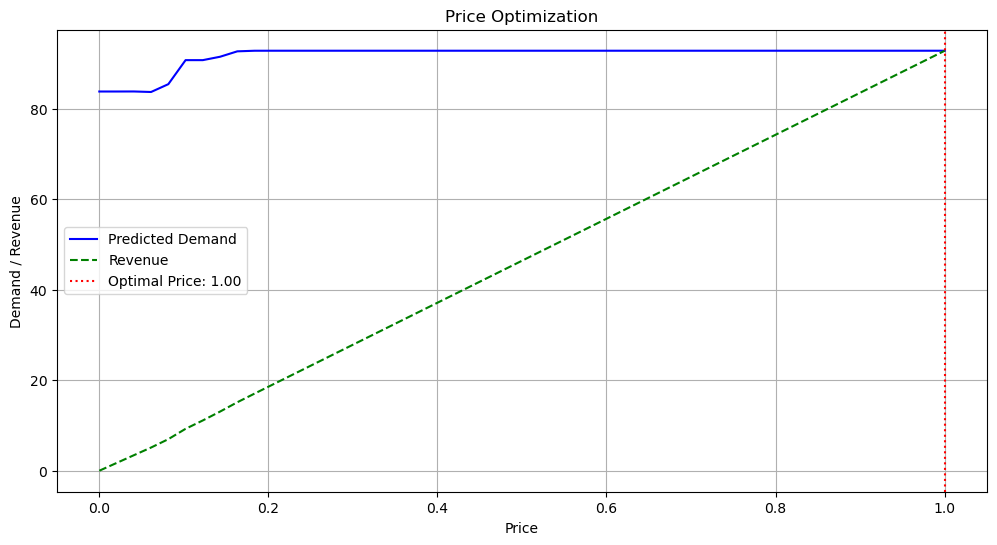

In [19]:
# Price Optimization
price_range = np.linspace(data['unit_price'].min(), data['unit_price'].max(), 50)

# Prepare simulated feature values
simulated_demand = []
for p in price_range:
    # Create a single row with all features
    row = [p]  # unit_price
    row.append(data['freight_price'].mean())  # freight_price
    row.append(data['Price_Elasticity'].mean())  # Price_Elasticity
    row.extend([
        data['comp_1'].mean(), data['comp_2'].mean(), data['comp_3'].mean(),
        data['unit_price freight_price'].mean(), data['unit_price comp_1'].mean(),
        data['unit_price comp_2'].mean(), data['unit_price comp_3'].mean(),
        data['freight_price comp_1'].mean(), data['freight_price comp_2'].mean(),
        data['freight_price comp_3'].mean(),
        data['comp_1 comp_2'].mean(), data['comp_1 comp_3'].mean(),
        data['comp_2 comp_3'].mean(),
        *[data[f].mean() for f in features if 'category_' in f]
    ])
    # Ensure the row has all required features
    simulated_demand.append(best_rf_model.predict([row])[0])

# Ensure non-negative demand predictions
simulated_demand = np.maximum(simulated_demand, 0)

# Find price that maximizes revenue
revenue = price_range * simulated_demand
optimal_price = price_range[np.argmax(revenue)]

print(f"Optimal Price: {optimal_price:.2f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(price_range, simulated_demand, label="Predicted Demand", color='blue')
plt.plot(price_range, revenue, label="Revenue", linestyle="--", color='green')
plt.axvline(optimal_price, color='red', linestyle=':', label=f"Optimal Price: {optimal_price:.2f}")
plt.title("Price Optimization")
plt.xlabel("Price")
plt.ylabel("Demand / Revenue")
plt.legend()
plt.grid(True)
plt.show()